In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
train = pd.read_csv("train_final.csv", index_col=['date'], parse_dates=['date'])
test = pd.read_csv("test_final.csv", index_col=['date'], parse_dates=['date'])

In [4]:
train = train[~(train.index < '2020-03-01')]
test = test[~(test.index < '2020-03-01')]

In [5]:
# build the model with one country with highest GDP per capita in each continent
# if data of multiple regions are available, use one region
# then apply the model to other countries in same continent
Luxembourg_train = train.loc[train.country_code == 'LU','new_confirmed'] # Europe
Singapore_train = train.loc[train.country_code == 'SG','new_confirmed'] # Asia
US_train = train.loc[train.location_key_x == 'US_AK','new_confirmed'] # North America
Australia_train = train.loc[train.location_key_x == 'AU_NT','new_confirmed'] # Oceania
Luxembourg_test = test.loc[test.country_code == 'LU','new_confirmed']
Singapore_test = test.loc[test.country_code == 'SG','new_confirmed']
US_test = test.loc[test.location_key_x == 'US_AK','new_confirmed']
Australia_test = test.loc[test.location_key_x == 'AU_NT','new_confirmed']

In [ ]:
Luxembourg_train_check = Luxembourg_train.values
result = adfuller(Luxembourg_train_check)
print('ADF: ', result[0])
print('p value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

ADF:  -0.09460580784394106
p value: 0.9499731724569667
Critical Values:
1% -3.4407890899441127
5% -2.8661459340578905
10% -2.5692228868342766


In [ ]:
# log data
from scipy.stats import norm, skew
log_Luxembourg_train = np.log1p(Luxembourg_train)
log_Luxembourg_test = np.log1p(Luxembourg_test)
Luxembourg_train_stationary = log_Luxembourg_train.diff().dropna()
Luxembourg_test_stationary = Luxembourg_train_stationary.diff().dropna()
# tried to make dataset stationary, does not work well

In [ ]:
Luxembourg_train_check = Luxembourg_train_stationary.values
result = adfuller(Luxembourg_train_check)
print('ADF: ', result[0])
print('p value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

ADF:  -7.82973547405417
p value: 6.340046319555896e-12
Critical Values:
1% -3.440890045708521
5% -2.8661904001753618
10% -2.569246579178572


In [ ]:
Luxembourg_model = ARIMA(Luxembourg_train, order=(2, 1, 1))
Luxembourg_model=Luxembourg_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


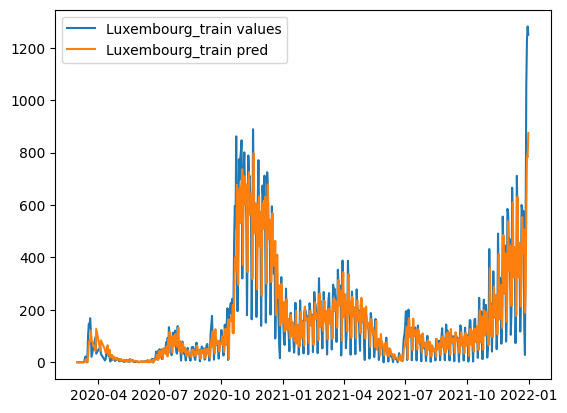

In [ ]:
Luxembourg_train_pred_NoTuning=Luxembourg_model.fittedvalues
plt.plot(Luxembourg_train)
plt.plot(Luxembourg_train_pred_NoTuning)
plt.legend(['Luxembourg_train values', 'Luxembourg_train pred'])

In [ ]:
# Luxembourg training rmse before tuning
np.sqrt(mean_squared_error(Luxembourg_train, Luxembourg_train_pred_NoTuning))

96.7667125095433

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


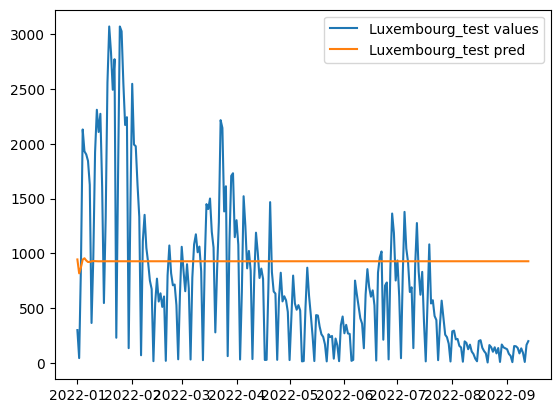

In [ ]:
start = '2022-01-01'
end = '2022-09-13'
date_range = pd.date_range(start=start, end=end)
Luxembourg_test_pred_NoTuning = Luxembourg_model.forecast(steps=len(date_range))
Luxembourg_test_pred_NoTuning_df = pd.DataFrame({'date': date_range, 'predicted_value': Luxembourg_test_pred_NoTuning})
Luxembourg_test_pred_NoTuning_df = Luxembourg_test_pred_NoTuning_df.set_index('date')
plt.plot(Luxembourg_test)
plt.plot(Luxembourg_test_pred_NoTuning_df)
plt.legend(['Luxembourg_test values', 'Luxembourg_test pred'])

In [ ]:
# Luxembourg test rmse before tuning
np.sqrt(mean_squared_error(Luxembourg_test, Luxembourg_test_pred_NoTuning_df))

711.9517068388466

In [ ]:
import itertools
param_grid_option = {
    'p': [1,2,3,4,5],
    'd': [0,1,2],
    'q': [1,2,3,4,5]}

all_params_combination = list(itertools.product(*param_grid_option.values()))
score = 100000
combination = None

for parameters in all_params_combination:
    arima_model = ARIMA(Luxembourg_train,order=(parameters)).fit()
    aic = arima_model.aic
    if aic < score:
      score = aic
      combination = parameters
    else:
      continue

In [ ]:
combination

(5, 1, 4)

In [10]:
Luxembourg_model = ARIMA(Luxembourg_train, order=(5, 1, 4))
Luxembourg_model=Luxembourg_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


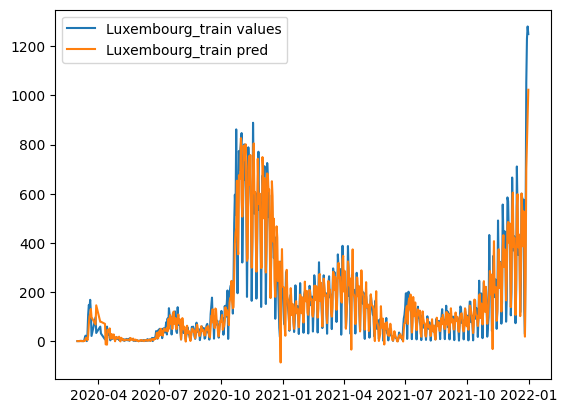

In [ ]:
Luxembourg_train_pred=Luxembourg_model.fittedvalues
plt.plot(Luxembourg_train)
plt.plot(Luxembourg_train_pred)
plt.legend(['Luxembourg_train values', 'Luxembourg_train pred'])

In [ ]:
# Luxembourg training rmse after tuning
np.sqrt(mean_squared_error(Luxembourg_train, Luxembourg_train_pred))

68.53638188662535

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


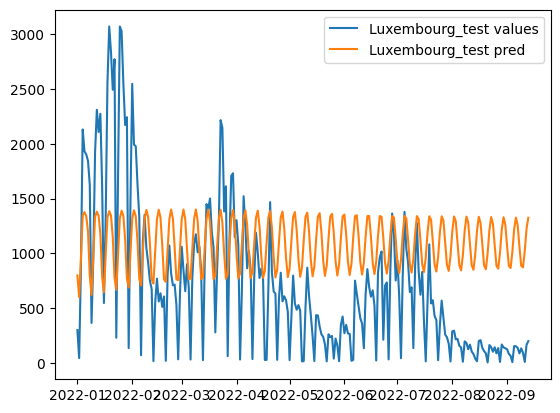

In [ ]:
start = '2022-01-01'
end = '2022-09-13'
date_range = pd.date_range(start=start, end=end)
Luxembourg_test_pred = Luxembourg_model.forecast(steps=len(date_range))
Luxembourg_test_pred_df = pd.DataFrame({'date': date_range, 'predicted_value': Luxembourg_test_pred})
Luxembourg_test_pred_df = Luxembourg_test_pred_df.set_index('date')
plt.plot(Luxembourg_test)
plt.plot(Luxembourg_test_pred_df)
plt.legend(['Luxembourg_test values', 'Luxembourg_test pred'])

In [ ]:
# Luxembourg test rmse after tuning
np.sqrt(mean_squared_error(Luxembourg_test, Luxembourg_test_pred))

733.3092809830803

In [ ]:
Singapore_train_check = Singapore_train.values
result = adfuller(Singapore_train_check)
print('ADF: ', result[0])
print('p value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

ADF:  -2.6747992092164554
p value: 0.07850154457981359
Critical Values:
1% -3.4404975024933813
5% -2.8660174956716795
10% -2.569154453750397


In [ ]:
Singapore_model = ARIMA(Singapore_train, order=(2, 1, 1))
Singapore_model=Singapore_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


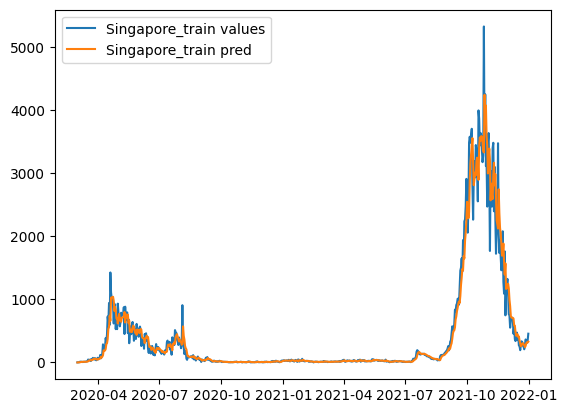

In [ ]:
Singapore_train_pred_NoTuning=Singapore_model.fittedvalues
plt.plot(Singapore_train)
plt.plot(Singapore_train_pred_NoTuning)
plt.legend(['Singapore_train values', 'Singapore_train pred'])

In [217]:
# Singapore training rmse before tuning
np.sqrt(mean_squared_error(Singapore_train, Singapore_train_pred_NoTuning))

209.27445327733437

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


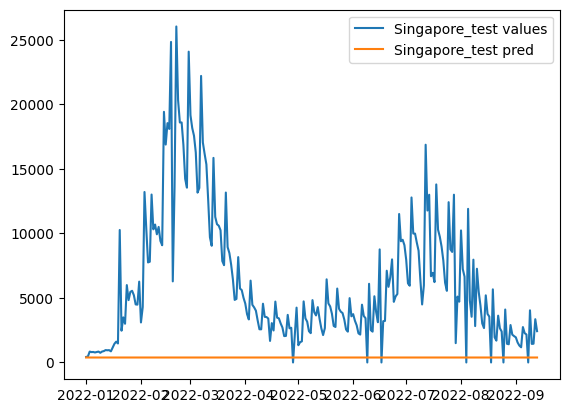

In [218]:
start = '2022-01-01'
end = '2022-09-13'
date_range = pd.date_range(start=start, end=end)
Singapore_test_pred_NoTuning = Singapore_model.forecast(steps=len(date_range))
Singapore_test_pred_NoTuning_df = pd.DataFrame({'date': date_range, 'predicted_value': Singapore_test_pred_NoTuning})
Singapore_test_pred_NoTuning_df = Singapore_test_pred_NoTuning_df.set_index('date')
plt.plot(Singapore_test)
plt.plot(Singapore_test_pred_NoTuning_df)
plt.legend(['Singapore_test values', 'Singapore_test pred'])

In [220]:
# Singapore test rmse before tuning
np.sqrt(mean_squared_error(Luxembourg_test, Luxembourg_test_pred_NoTuning_df))

733.3092809830803

In [ ]:
import itertools
param_grid_option = {
    'p': [1,2,3,4,5],
    'd': [0,1,2],
    'q': [1,2,3,4,5]}

all_params_combination = list(itertools.product(*param_grid_option.values()))
score = 100000
Singapore_combination = None

for parameters in all_params_combination:
    arima_model = ARIMA(Singapore_train,order=(parameters)).fit()
    aic = arima_model.aic
    if aic < score:
      score = aic
      Singapore_combination = parameters
    else:
      continue

In [224]:
Singapore_combination

(5, 1, 4)

In [11]:
Singapore_model = ARIMA(Singapore_train, order=(5, 1, 4))
Singapore_model=Singapore_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


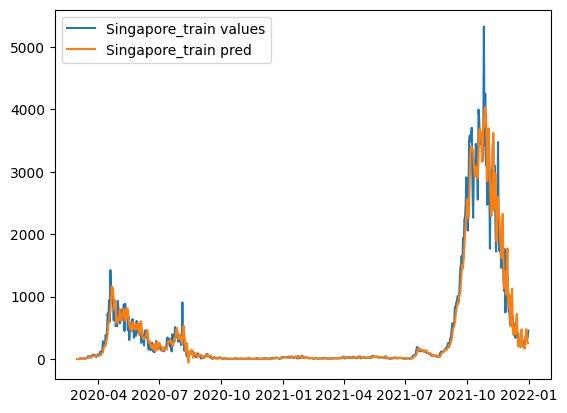

In [226]:
Singapore_train_pred=Singapore_model.fittedvalues
plt.plot(Singapore_train)
plt.plot(Singapore_train_pred)
plt.legend(['Singapore_train values', 'Singapore_train pred'])

In [227]:
# Singapore training rmse after tuning
np.sqrt(mean_squared_error(Singapore_train, Singapore_train_pred))

179.5149534343421

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


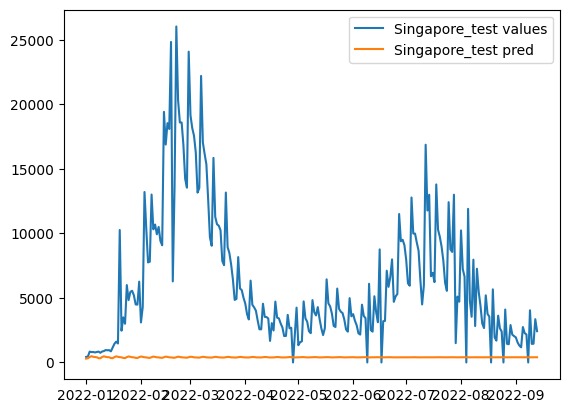

In [228]:
start = '2022-01-01'
end = '2022-09-13'
date_range = pd.date_range(start=start, end=end)
Singapore_test_pred = Singapore_model.forecast(steps=len(date_range))
Singapore_test_pred_df = pd.DataFrame({'date': date_range, 'predicted_value': Singapore_test_pred})
Singapore_test_pred_df = Singapore_test_pred_df.set_index('date')
plt.plot(Singapore_test)
plt.plot(Singapore_test_pred_df)
plt.legend(['Singapore_test values', 'Singapore_test pred'])

In [229]:
# Singapore test rmse after tuning
np.sqrt(mean_squared_error(Singapore_test, Singapore_test_pred))

7746.574513995646

In [230]:
US_train_check = US_train.values
result = adfuller(US_train_check)
print('ADF: ', result[0])
print('p value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

ADF:  -1.830092753666288
p value: 0.3656271050912414
Critical Values:
1% -3.4404038931945276
5% -2.865976260062519
10% -2.5691324834372633


In [231]:
US_model = ARIMA(US_train, order=(2, 1, 1))
US_model=US_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


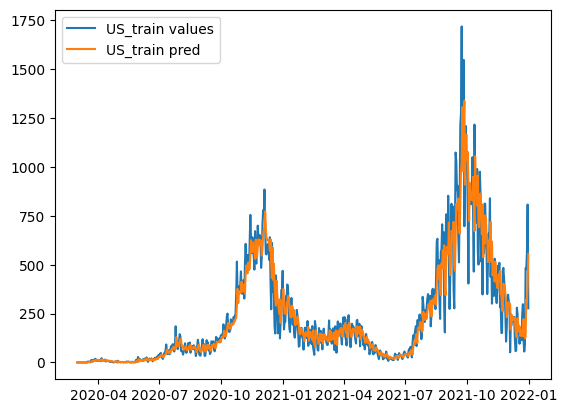

In [232]:
US_train_pred_NoTuning=US_model.fittedvalues
plt.plot(US_train)
plt.plot(US_train_pred_NoTuning)
plt.legend(['US_train values', 'US_train pred'])

In [233]:
# US training rmse before tuning
np.sqrt(mean_squared_error(US_train, US_train_pred_NoTuning))

105.07288135442417

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


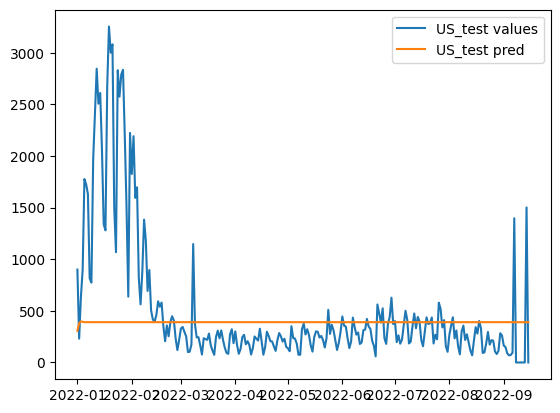

In [237]:
start = '2022-01-01'
end = '2022-09-15'
date_range = pd.date_range(start=start, end=end)
US_test_pred_NoTuning = US_model.forecast(steps=len(date_range))
US_test_pred_NoTuning_df = pd.DataFrame({'date': date_range, 'predicted_value': US_test_pred_NoTuning})
US_test_pred_NoTuning_df = US_test_pred_NoTuning_df.set_index('date')
plt.plot(US_test)
plt.plot(US_test_pred_NoTuning_df)
plt.legend(['US_test values', 'US_test pred'])

In [238]:
# US test rmse before tuning
np.sqrt(mean_squared_error(US_test, US_test_pred_NoTuning_df))

663.5997988750148

In [ ]:
import itertools
param_grid_option = {
    'p': [1,2,3,4,5],
    'd': [0,1,2],
    'q': [1,2,3,4,5]}

all_params_combination = list(itertools.product(*param_grid_option.values()))
score = 100000
US_combination = None

for parameters in all_params_combination:
    arima_model = ARIMA(US_train,order=(parameters)).fit()
    aic = arima_model.aic
    if aic < score:
      score = aic
      US_combination = parameters
    else:
      continue

In [240]:
US_combination

(5, 1, 5)

In [8]:
US_model = ARIMA(US_train, order=(5, 1, 5))
US_model=US_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


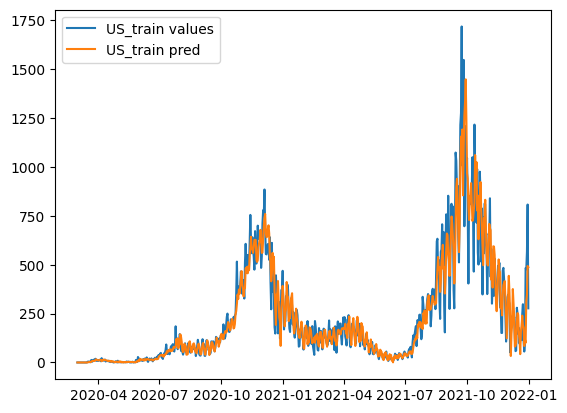

In [9]:
US_train_pred=US_model.fittedvalues
plt.plot(US_train)
plt.plot(US_train_pred)
plt.legend(['US_train values', 'US_train pred'])

In [12]:
# US training rmse after tuning
np.sqrt(mean_squared_error(US_train, US_train_pred))

91.80150102611678

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


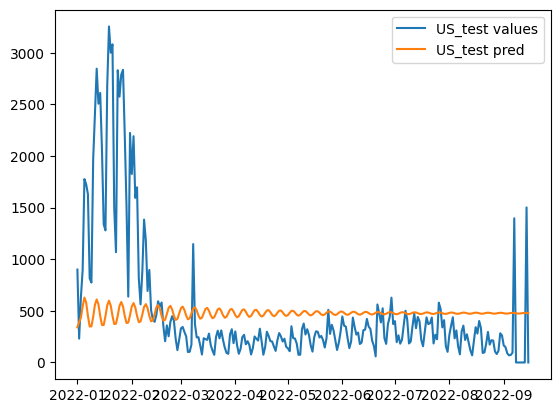

In [17]:
start = '2022-01-01'
end = '2022-09-15'
date_range = pd.date_range(start=start, end=end)
US_test_pred = US_model.forecast(steps=len(date_range))
US_test_pred_df = pd.DataFrame({'date': date_range, 'predicted_value': US_test_pred})
US_test_pred_df = US_test_pred_df.set_index('date')
plt.plot(US_test)
plt.plot(US_test_pred_df)
plt.legend(['US_test values', 'US_test pred'])

In [18]:
# US test rmse after tuning
np.sqrt(mean_squared_error(US_test, US_test_pred))

644.4776923202617

In [19]:
Australia_train_check =Australia_train.values
result = adfuller(Australia_train_check)
print('ADF: ', result[0])
print('p value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(key, value)

ADF:  8.453993895525809
p value: 1.0
Critical Values:
1% -3.440466106307706
5% -2.8660036655537744
10% -2.569147085049656


In [20]:
Australia_model = ARIMA(Australia_train, order=(2, 1, 1))
Australia_model=Australia_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

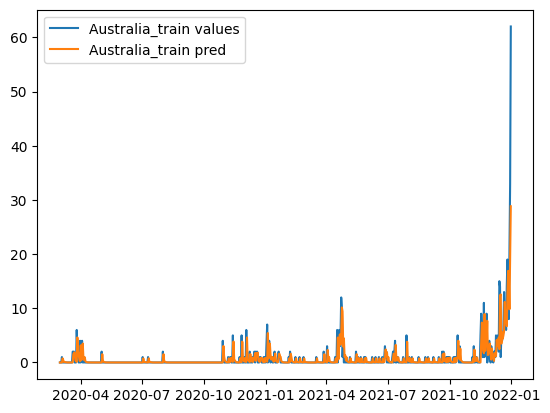

In [21]:
Australia_train_pred_NoTuning=Australia_model.fittedvalues
plt.plot(Australia_train)
plt.plot(Australia_train_pred_NoTuning)
plt.legend(['Australia_train values', 'Australia_train pred'])

In [22]:
# Australia training rmse before tuning
np.sqrt(mean_squared_error(Australia_train, Australia_train_pred_NoTuning))

2.1966857292668918

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


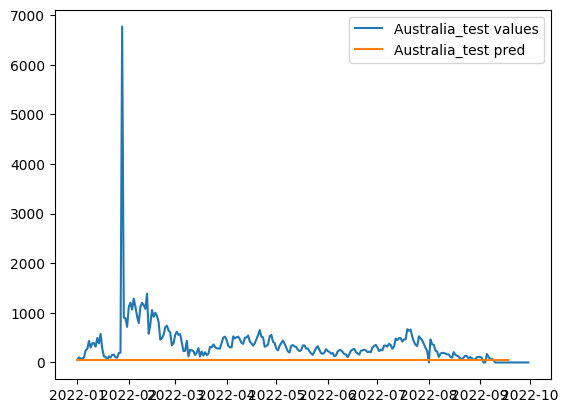

In [39]:
start = '2022-01-01'
end = '2022-09-18'
date_range = pd.date_range(start=start, end=end)
Australia_test_pred_NoTuning = Australia_model.forecast(steps=len(date_range))
Australia_test_pred_NoTuning_df = pd.DataFrame({'date': date_range, 'predicted_value': Australia_test_pred_NoTuning})
Australia_test_pred_NoTuning_df = Australia_test_pred_NoTuning_df.set_index('date')
plt.plot(Australia_test)
plt.plot(Australia_test_pred_NoTuning_df)
plt.legend(['Australia_test values', 'Australia_test pred'])

In [40]:
# Australia test rmse before tuning
np.sqrt(mean_squared_error(Australia_test, Australia_test_pred_NoTuning_df))

571.3088804734473

In [ ]:
import itertools
param_grid_option = {
    'p': [1,2,3,4,5],
    'd': [0,1,2],
    'q': [1,2,3,4,5]}

all_params_combination = list(itertools.product(*param_grid_option.values()))
score = 100000
Australia_combination = None

for parameters in all_params_combination:
    arima_model = ARIMA(Australia_train,order=(parameters)).fit()
    aic = arima_model.aic
    if aic < score:
      score = aic
      Australia_combination = parameters
    else:
      continue

In [42]:
Australia_combination

(5, 2, 3)

In [43]:
Australia_model = ARIMA(Australia_train, order=(5, 2, 3))
Australia_model=Australia_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


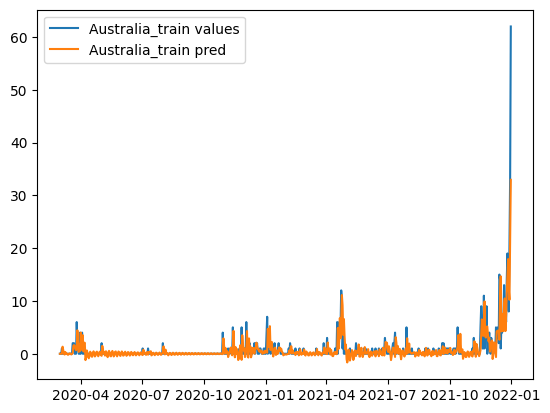

In [44]:
Australia_train_pred=Australia_model.fittedvalues
plt.plot(Australia_train)
plt.plot(Australia_train_pred)
plt.legend(['Australia_train values', 'Australia_train pred'])

In [45]:
# Australia training rmse after tuning
np.sqrt(mean_squared_error(Australia_train, Australia_train_pred))

2.060136876090627

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


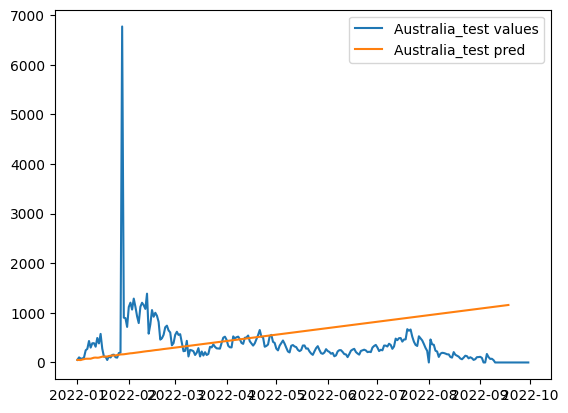

In [48]:
start = '2022-01-01'
end = '2022-09-18'
date_range = pd.date_range(start=start, end=end)
Australia_test_pred = Australia_model.forecast(steps=len(date_range))
Australia_test_pred_df = pd.DataFrame({'date': date_range, 'predicted_value': Australia_test_pred})
Australia_test_pred_df = Australia_test_pred_df.set_index('date')
plt.plot(Australia_test)
plt.plot(Australia_test_pred_df)
plt.legend(['Australia_test values', 'Australia_test pred'])

In [49]:
# Australia test rmse after tuning
np.sqrt(mean_squared_error(Australia_test, Australia_test_pred))

695.945708884639

In [50]:
# apply to all countries
# Luxembourg_model_final for European countries
# Singapore_model_final for Asian countries
# US_model_final for countries in North America - only US in top 10
# Australia_model_final for Oceania countries - only Australia in top 10
Ireland_train = train.loc[train.country_code == 'IE','new_confirmed'] # Europe
Qatar_train = train.loc[train.country_code == 'QA','new_confirmed'] # Asia
Iceland_train = train.loc[train.country_code == 'IS','new_confirmed'] # Europe
Denmark_train = train.loc[train.country_code == 'DK','new_confirmed'] # Europe

Ireland_test = test.loc[test.country_code == 'IE','new_confirmed'] # Europe
Qatar_test = test.loc[test.country_code == 'QA','new_confirmed'] # Asia
Iceland_test = test.loc[test.country_code == 'IS','new_confirmed'] # Europe
Denmark_test = test.loc[test.country_code == 'DK','new_confirmed'] # Europe

In [66]:
# Ireland using Luxembourg model
test_start = '2022-01-01'
test_end = '2022-09-13'
test_date_range = pd.date_range(start=test_start, end=test_end)
Ireland_test_pred = Luxembourg_model.forecast(steps=len(test_date_range))
Ireland_test_pred_df = pd.DataFrame({'date': test_date_range, 'predicted_value': Ireland_test_pred})
Ireland_test_pred_df = Ireland_test_pred_df.set_index('date')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [67]:
# Ireland test rmse
np.sqrt(mean_squared_error(Ireland_test,Ireland_test_pred_df))

5116.5484111626365

In [68]:
# Qatar using Singapore model
test_start = '2022-01-01'
test_end = '2022-09-13'
test_date_range = pd.date_range(start=test_start, end=test_end)
Qatar_test_pred = Luxembourg_model.forecast(steps=len(test_date_range))
Qatar_test_pred_df = pd.DataFrame({'date': test_date_range, 'predicted_value': Qatar_test_pred})
Qatar_test_pred_df = Qatar_test_pred_df.set_index('date')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [69]:
# Qatar test rmse
np.sqrt(mean_squared_error(Qatar_test,Qatar_test_pred_df))

1014.8444248714214

In [70]:
# Iceland using Luxembourg model
test_start = '2022-01-01'
test_end = '2022-09-13'
test_date_range = pd.date_range(start=test_start, end=test_end)
Iceland_test_pred = Luxembourg_model.forecast(steps=len(test_date_range))
Iceland_test_pred_df = pd.DataFrame({'date': test_date_range, 'predicted_value': Iceland_test_pred})
Iceland_test_pred_df = Iceland_test_pred_df.set_index('date')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [71]:
# Iceland test rmse
np.sqrt(mean_squared_error(Iceland_test,Iceland_test_pred_df))

981.1533359944592

In [72]:
# Denmark using Luxembourg model
test_start = '2022-01-01'
test_end = '2022-09-13'
test_date_range = pd.date_range(start=test_start, end=test_end)
Denmark_test_pred = Luxembourg_model.forecast(steps=len(test_date_range))
Denmark_test_pred_df = pd.DataFrame({'date': test_date_range, 'predicted_value': Denmark_test_pred})
Denmark_test_pred_df = Denmark_test_pred_df.set_index('date')

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [73]:
# Denmark test rmse
np.sqrt(mean_squared_error(Denmark_test,Denmark_test_pred_df))

16800.402122988133